<a href="https://colab.research.google.com/github/sofitacal/TPS/blob/main/PIB(test).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip -q install nibabel SimpleITK matplotlib
!pip -q install SimpleITK

from google.colab import drive
drive.mount('/content/drive')


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 MB 9.4 MB/s eta 0:00:00
Mounted at /content/drive


In [2]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

path = "/content/drive/MyDrive/OASIS 1/disc1/OAS1_0001_MR1/RAW/OAS1_0001_MR1_mpr-1_anon.hdr"


img = nib.load(path)
data = img.get_fdata()
#print("Shape:", data.shape)


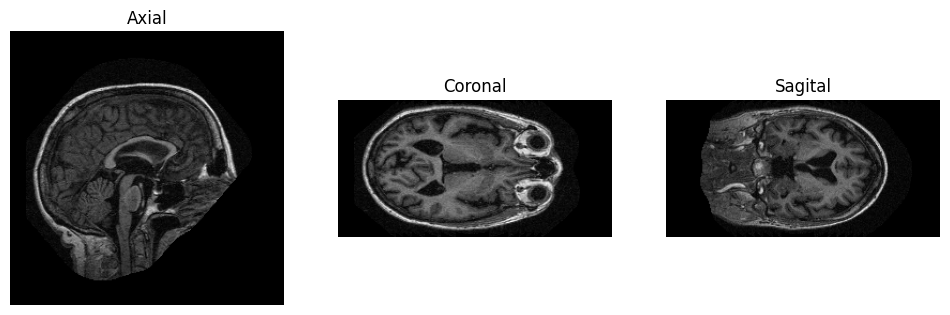

In [3]:
data = np.squeeze(data) #esto es necesario pq por alguna razon hay un cuatro canal (eje x, eje y, eje z, canal extra)
#print("Nuevo shape:", data.shape)

cx, cy, cz = [s//2 for s in data.shape]

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(data[:,:,cz].T, cmap='gray', origin='lower'); plt.title('Axial'); plt.axis('off')
plt.subplot(1,3,2); plt.imshow(data[:,cy,:].T, cmap='gray', origin='lower'); plt.title('Coronal'); plt.axis('off')
plt.subplot(1,3,3); plt.imshow(data[cx,:,:].T, cmap='gray', origin='lower'); plt.title('Sagital'); plt.axis('off')
plt.show()


In [ ]:
import SimpleITK as sitk
import os, nibabel as nib, numpy as np

in_path = path  # el .hdr que cargaste antes
out_dir = os.path.dirname(in_path)

# 1) Leer y CASTEAR
sitk_img_orig = sitk.ReadImage(in_path)           # int16
sitk_img = sitk.Cast(sitk_img_orig, sitk.sitkFloat32)  # <-- N4 requiere float

# 2) Máscara gruesa (uint8)
brain_hint = sitk.OtsuThreshold(sitk_img, 0, 1, 200)
brain_hint = sitk.Cast(brain_hint, sitk.sitkUInt8)

# 3) N4 (con iteraciones razonables)
n4 = sitk.N4BiasFieldCorrectionImageFilter()
n4.SetMaximumNumberOfIterations([50,50,30,20])   # opcional
img_n4 = n4.Execute(sitk_img, brain_hint)

# 4) Guardar como NIfTI
n4_path = os.path.join(out_dir, "n4_corrected.nii.gz")
sitk.WriteImage(img_n4, n4_path)
print("OK ->", n4_path)



In [ ]:
import nibabel as nib
import numpy as np
import scipy.ndimage as ndi
import matplotlib.pyplot as plt

# === Cargar el archivo corregido con N4 ===
nii = nib.load(n4_path)
vol = np.asarray(nii.get_fdata(), dtype=np.float32)

# === Crear máscara gruesa inicial (brain_mask) ===
# usamos umbral de intensidad y operaciones morfológicas
th = np.percentile(vol, 40)  # umbral: descarta fondo
brain_mask = vol > th
brain_mask = ndi.binary_opening(brain_mask, iterations=1)
brain_mask = ndi.binary_closing(brain_mask, iterations=2)
brain_mask = ndi.binary_fill_holes(brain_mask)

# === Mejora del skull stripping ===
# 1. Eliminar componentes pequeñas fuera del cerebro
lab, n = ndi.label(brain_mask)
sizes = ndi.sum(brain_mask, lab, range(1, n+1))
main_label = np.argmax(sizes) + 1
brain_mask = (lab == main_label)

# 2. Cerrar huecos dentro del cerebro y quitar bordes finos
brain_mask = ndi.binary_closing(brain_mask, iterations=3)
brain_mask = ndi.binary_opening(brain_mask, iterations=1)
brain_mask = ndi.binary_fill_holes(brain_mask)

# 3. Opcional: cortar cuello (parte inferior)
zmin, zmax = 5, vol.shape[2] - 5   # elimina primeras y últimas 5 slices
brain_mask[:, :, :zmin] = False
brain_mask[:, :, zmax:] = False

# 4. Aplicar máscara mejorada
brain_only = vol * brain_mask

# QC
cz = vol.shape[2] // 2
plt.figure(figsize=(6,6))
plt.imshow(brain_only[:,:,cz].T, cmap='gray', origin='lower')
plt.title("QC: cerebro limpio (sin cuello ni piel)")
plt.axis('off')
plt.show()


In [ ]:
import numpy as np, nibabel as nib

# 1) bounding box del cerebro
coords = np.array(np.where(brain_mask))
(zmin,ymin,xmin) = coords.min(axis=1)
(zmax,ymax,xmax) = coords.max(axis=1)  # inclusive

# 2) padding para no cortar borde (en voxeles)
pad = 8
z0 = max(0, zmin - pad); z1 = min(vol.shape[0], zmax + pad + 1)
y0 = max(0, ymin - pad); y1 = min(vol.shape[1], ymax + pad + 1)
x0 = max(0, xmin - pad); x1 = min(vol.shape[2], xmax + pad + 1)

vol_crop = vol[z0:z1, y0:y1, x0:x1]
mask_crop = brain_mask[z0:z1, y0:y1, x0:x1]

# 3) actualizar affine (traslación por el recorte)
aff = nii.affine.copy()
aff[:3,3] = aff[:3,3] + aff[:3,:3] @ np.array([z0, y0, x0])

nii_crop = nib.Nifti1Image(vol_crop, aff, header=nii.header)
nib.save(nii_crop, n4_path.replace("n4_corrected.nii.gz","n4_corrected_crop.nii.gz"))
nib.save(nib.Nifti1Image(mask_crop.astype(np.uint8), aff, nii.header),
         n4_path.replace("n4_corrected.nii.gz","brain_mask_crop.nii.gz"))

print("Crop cerebro:", vol_crop.shape)


In [ ]:
import matplotlib.pyplot as plt
import nibabel as nib

# Cargar el archivo recortado
nii_crop = nib.load(n4_path.replace("n4_corrected.nii.gz","n4_corrected_crop.nii.gz"))
vol_crop = nii_crop.get_fdata()

# Mostrar algunos cortes representativos
fig, axs = plt.subplots(1, 3, figsize=(12,4))

cz = vol_crop.shape[2] // 2
cy = vol_crop.shape[1] // 2
cx = vol_crop.shape[0] // 2

axs[0].imshow(vol_crop[:,:,cz].T, cmap='gray', origin='lower')
axs[0].set_title('Axial (z medio)')
axs[1].imshow(vol_crop[:,cy,:].T, cmap='gray', origin='lower')
axs[1].set_title('Coronal (y medio)')
axs[2].imshow(vol_crop[cx,:,:].T, cmap='gray', origin='lower')
axs[2].set_title('Sagital (x medio)')

for ax in axs: ax.axis('off')
plt.show()



In [ ]:
import nibabel as nib, numpy as np, scipy.ndimage as ndi, matplotlib.pyplot as plt

# === AJUSTÁ ESTAS 2 RUTAS (usa el .hdr del par .hdr/.img) ===
fseg_path = "/content/drive/MyDrive/OASIS 1/disc1/OAS1_0001_MR1/FSL_SEG/OAS1_0001_MR1_mpr_n4_anon_111_t88_masked_gfc_fseg.hdr"
t1_path   = "/content/drive/MyDrive/OASIS 1/disc1/OAS1_0001_MR1/PROCESSED/T88_111/OAS1_0001_MR1_mpr_n4_anon_111_t88_masked_gfc.hdr"
# ============================================================

# 1) Cargar segmentación FSL (1=CSF) y el T1 skull-stripped correspondiente
seg = nib.load(fseg_path); seg_data = seg.get_fdata().astype(np.int16)
t1  = nib.load(t1_path);   vol      = t1.get_fdata().astype(np.float32)
vox_mm3 = float(np.prod(t1.header.get_zooms()[:3]))

# 2) CSF de FSL + máscara de cerebro rápida (por si el fseg trae bordes)
brain_mask = vol > np.percentile(vol[vol>0], 40)
csf = (seg_data == 1)

# 3) Filtrar para quedarnos solo con ventrículos laterales
#    (quita LCR de surcos con distancia al borde + tamaño + cercanía a línea media)
dist = ndi.distance_transform_edt(brain_mask)
interior = dist > 6        # si entra surco: 7–8 | si queda vacío: 5
csf_core = csf & interior

csf_core = ndi.binary_opening(csf_core, iterations=1)
csf_core = ndi.binary_closing(csf_core, iterations=1)

lab, n = ndi.label(csf_core)
xs = np.arange(csf_core.shape[0]); mid_x = xs.mean()
MIN_SIZE, MAX_DIST = 600, 45  # más grande/menor distancia = más estricto

cands = []
for k in range(1, n+1):
    idx  = np.where(lab==k)
    size = len(idx[0])
    if size < MIN_SIZE:
        continue
    cx = float(np.mean(idx[0]))
    if abs(cx - mid_x) < MAX_DIST:
        cands.append((size,k))

# quedarnos con las 2 componentes más grandes (ventrículos laterales)
ventricles = np.zeros_like(csf_core, dtype=bool)
for _, k in sorted(cands, reverse=True)[:2]:
    ventricles[lab==k] = True

ventricles = ndi.binary_closing(ventricles, iterations=1)
ventricles = ndi.binary_opening(ventricles, iterations=1)

print("componentes:", len(cands), "| vox ventrículos:", int(ventricles.sum()))

# 4) Separar hemisferios y calcular volúmenes + AI
left_mask  = ventricles.copy()
right_mask = ventricles.copy()
left_mask[int(np.floor(mid_x)):, :, :] = False
right_mask[:int(np.floor(mid_x)), :, :] = False

V_left_ml  = left_mask.sum()  * vox_mm3 / 1000.0
V_right_ml = right_mask.sum() * vox_mm3 / 1000.0
AI = (V_left_ml - V_right_ml) / ((V_left_ml + V_right_ml)/2.0) * 100.0
print(f"V Izq: {V_left_ml:.2f} ml | V Der: {V_right_ml:.2f} ml | AI: {AI:.2f}%")

# 5) QC visual (slice central)
cz = ventricles.shape[2]//2
plt.figure(figsize=(6,6))
plt.imshow((vol/vol.max())[:,:,cz].T, cmap='gray', origin='lower')
yy, xx = np.where(ventricles[:,:,cz].T); plt.scatter(xx, yy, s=1)
plt.title("Ventrículos (QC con FSL_SEG)"); plt.axis('off'); plt.show()

# 6) Guardar máscaras NIfTI para tu informe
outdir = "/".join(t1_path.split("/")[:-1])
nib.save(nib.Nifti1Image(ventricles.astype(np.uint8), t1.affine, t1.header),
         f"{outdir}/mask_ventricles.nii.gz")
nib.save(nib.Nifti1Image(left_mask.astype(np.uint8), t1.affine, t1.header),
         f"{outdir}/mask_left_lv.nii.gz")
nib.save(nib.Nifti1Image(right_mask.astype(np.uint8), t1.affine, t1.header),
         f"{outdir}/mask_right_lv.nii.gz")
print("Máscaras guardadas en:", outdir)
